In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from scipy.io import arff
import pandas as pd

# Import the data
# Uncomment exactly one of these lines

arff_data = arff.loadarff('/content/drive/MyDrive/NetworkTrafficNet/ScenarioB/TimeBasedFeatures-Dataset-15s.arff')
# arff_data = arff.loadarff('/content/drive/MyDrive/NetworkTrafficNet/ScenarioB/TimeBasedFeatures-Dataset-15s-AllinOne.arff')
# arff_data = arff.loadarff('/content/drive/MyDrive/NetworkTrafficNet/ScenarioB/TimeBasedFeatures-Dataset-30s.arff')
# arff_data = arff.loadarff('/content/drive/MyDrive/NetworkTrafficNet/ScenarioB/TimeBasedFeatures-Dataset-30s-AllinOne.arff')
# arff_data = arff.loadarff('/content/drive/MyDrive/NetworkTrafficNet/ScenarioB/TimeBasedFeatures-Dataset-60s.arff')
# arff_data = arff.loadarff('/content/drive/MyDrive/NetworkTrafficNet/ScenarioB/TimeBasedFeatures-Dataset-60s-AllinOne.arff')
# arff_data = arff.loadarff('/content/drive/MyDrive/NetworkTrafficNet/ScenarioB/TimeBasedFeatures-Dataset-120s.arff')
# arff_data = arff.loadarff('/content/drive/MyDrive/NetworkTrafficNet/ScenarioB/TimeBasedFeatures-Dataset-120s-AllinOne.arff')

data = pd.DataFrame(arff_data[0])
data.head()

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,flowBytesPerSecond,min_flowiat,max_flowiat,mean_flowiat,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
0,9368711.0,16.0,4.0,1564818.0,1549373.0,190205.285714,203290.456522,389822.391917,370323.719754,10.353612,4802.688438,4.0,1523088.0,97590.739583,267600.198443,1871488.0,1.983656e+06,2195089.0,1.832197e+05,1234883.0,1420565.0,1523088.0,161096.539275,b'CHAT'
1,7340238.0,18.0,4.0,1567554.0,1527893.0,165686.977273,186914.846154,317267.548742,304370.651301,11.580006,4340.186245,4.0,1517774.0,87383.785714,221462.862028,1491627.0,3.572433e+06,5653239.0,2.942704e+06,1131498.0,1324636.0,1517774.0,273138.379008,b'CHAT'
2,4644225.0,29.0,15.0,1270547.0,1079974.0,165865.178571,195302.130435,329473.126261,300492.588227,11.412022,4161.512416,15.0,1079974.0,89312.019231,217475.425246,1758922.0,1.758922e+06,1758922.0,0.000000e+00,1079974.0,1079974.0,1079974.0,0.000000,b'CHAT'
3,4978735.0,19.0,8.0,2492050.0,2457286.0,239543.250000,276596.388889,612435.304238,628339.573544,8.034169,3918.666087,8.0,2441990.0,127659.871795,436959.716436,1710925.0,2.382905e+06,3054885.0,9.503232e+05,1346073.0,1894031.5,2441990.0,774930.342317,b'CHAT'
4,11838189.0,19.0,10.0,3094089.0,3093543.0,243766.500000,295954.725000,599721.781709,625632.703972,7.602514,2802.540152,10.0,3042717.0,133013.359551,436129.639296,1747431.0,2.400446e+06,3240696.0,6.232744e+05,1394455.0,1983227.0,3042717.0,725987.829075,b'CHAT'


In [5]:
# One-hot encode the data
one_hot_data = pd.get_dummies(data, columns=['class1'])
one_hot_data.head()

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,flowBytesPerSecond,min_flowiat,max_flowiat,mean_flowiat,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1_b'BROWSING',class1_b'CHAT',class1_b'FT',class1_b'MAIL',class1_b'P2P',class1_b'STREAMING',class1_b'VOIP',class1_b'VPN-BROWSING',class1_b'VPN-CHAT',class1_b'VPN-FT',class1_b'VPN-MAIL',class1_b'VPN-P2P',class1_b'VPN-STREAMING',class1_b'VPN-VOIP'
0,9368711.0,16.0,4.0,1564818.0,1549373.0,190205.285714,203290.456522,389822.391917,370323.719754,10.353612,4802.688438,4.0,1523088.0,97590.739583,267600.198443,1871488.0,1.983656e+06,2195089.0,1.832197e+05,1234883.0,1420565.0,1523088.0,161096.539275,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,7340238.0,18.0,4.0,1567554.0,1527893.0,165686.977273,186914.846154,317267.548742,304370.651301,11.580006,4340.186245,4.0,1517774.0,87383.785714,221462.862028,1491627.0,3.572433e+06,5653239.0,2.942704e+06,1131498.0,1324636.0,1517774.0,273138.379008,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,4644225.0,29.0,15.0,1270547.0,1079974.0,165865.178571,195302.130435,329473.126261,300492.588227,11.412022,4161.512416,15.0,1079974.0,89312.019231,217475.425246,1758922.0,1.758922e+06,1758922.0,0.000000e+00,1079974.0,1079974.0,1079974.0,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4978735.0,19.0,8.0,2492050.0,2457286.0,239543.250000,276596.388889,612435.304238,628339.573544,8.034169,3918.666087,8.0,2441990.0,127659.871795,436959.716436,1710925.0,2.382905e+06,3054885.0,9.503232e+05,1346073.0,1894031.5,2441990.0,774930.342317,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,11838189.0,19.0,10.0,3094089.0,3093543.0,243766.500000,295954.725000,599721.781709,625632.703972,7.602514,2802.540152,10.0,3042717.0,133013.359551,436129.639296,1747431.0,2.400446e+06,3240696.0,6.232744e+05,1394455.0,1983227.0,3042717.0,725987.829075,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
# Separate the data into test and training
train_data = one_hot_data.sample(frac=0.8)
test_data = one_hot_data.drop(train_data.index)

# Separate the labels from the input features
class_columns = ["class1_b'BROWSING'", "class1_b'CHAT'", "class1_b'FT'", "class1_b'MAIL'", "class1_b'P2P'", "class1_b'STREAMING'", "class1_b'VOIP'", "class1_b'VPN-BROWSING'", "class1_b'VPN-CHAT'", "class1_b'VPN-FT'", "class1_b'VPN-MAIL'", "class1_b'VPN-P2P'", "class1_b'VPN-STREAMING'", "class1_b'VPN-VOIP'"]
x_train = train_data.drop(class_columns, axis=1)
y_train = train_data[class_columns]

# Normalize (This step is a bit suspect, since the columns are interrelated (min, max, mean, std))
x_train = (x_train - x_train.min()) / (x_train.max() - x_train.min())

# Same for test data
x_test = test_data.drop(class_columns, axis=1)
y_test = test_data[class_columns]

x_test = (x_test - x_test.min()) / (x_test.max() - x_test.min())

print('Training Data\n', x_train.describe().transpose(), '\n')
print('Test Data\n', x_test.describe().transpose(), '\n')

Training Data
                       count      mean       std  ...           50%       75%  max
duration            15006.0  0.016312  0.024633  ...  1.853120e-02  0.024855  1.0
total_fiat          15006.0  0.016055  0.059470  ...  1.671940e-06  0.000045  1.0
total_biat          15006.0  0.014494  0.054163  ...  5.115996e-07  0.000034  1.0
min_fiat            15006.0  0.010776  0.035117  ...  9.308513e-04  0.014044  1.0
min_biat            15006.0  0.004814  0.017071  ...  4.688360e-04  0.007067  1.0
max_fiat            15006.0  0.006586  0.021371  ...  3.348407e-04  0.003419  1.0
max_biat            15006.0  0.021418  0.058108  ...  7.908698e-04  0.011205  1.0
mean_fiat           15006.0  0.003895  0.020852  ...  5.544236e-05  0.002864  1.0
mean_biat           15006.0  0.006312  0.025921  ...  1.062994e-04  0.005518  1.0
flowPktsPerSecond   15006.0  0.002080  0.020092  ...  1.167565e-05  0.000101  1.0
flowBytesPerSecond  15006.0  0.000736  0.014371  ...  4.301921e-06  0.000022  1.0
m

In [16]:
import tensorflow as tf

model = tf.keras.Sequential([
  tf.keras.layers.InputLayer([len(x_train.keys())], name="Input_Layer"),
  tf.keras.layers.Dense(32, activation='relu', name="dense_01"),
  tf.keras.layers.Dense(32, activation='relu', name="dense_02"),
  tf.keras.layers.Dense(len(y_train.keys()), name="Output_Layer")
])

model.compile(loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_01 (Dense)             (None, 32)                768       
_________________________________________________________________
dense_02 (Dense)             (None, 32)                1056      
_________________________________________________________________
Output_Layer (Dense)         (None, 14)                462       
Total params: 2,286
Trainable params: 2,286
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_split=0.2, verbose=1)

Epoch 1/100
94/94 [==============================] - 1s 5ms/step - loss: 0.0657 - val_loss: 0.0614
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0610 - val_loss: 0.0589
Epoch 3/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0568
Epoch 4/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0570 - val_loss: 0.0553
Epoch 5/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0541
Epoch 6/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0537
Epoch 7/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0532
Epoch 8/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0529
Epoch 9/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0525
Epoch 10/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0524
Epoch 11/

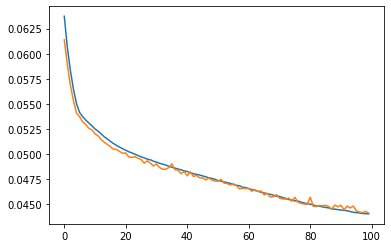

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
_ = plt.plot(history.history['val_loss'])

In [19]:
history2 = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_split=0.2, verbose=1)

Epoch 1/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0439 - val_loss: 0.0442
Epoch 2/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0441
Epoch 3/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0442
Epoch 4/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0441
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0438 - val_loss: 0.0439
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0437 - val_loss: 0.0439
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0437 - val_loss: 0.0440
Epoch 8/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0437
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0436 - val_loss: 0.0437
Epoch 10/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0442
Epoch 11/

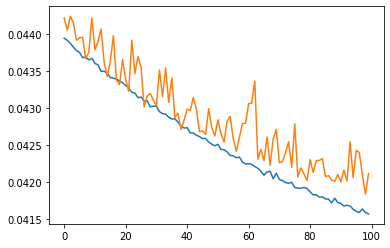

In [22]:
plt.plot(history2.history['loss'])
_ = plt.plot(history2.history['val_loss'])

In [23]:
history3 = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_split=0.2, verbose=1)

Epoch 1/100
94/94 [==============================] - 0s 4ms/step - loss: 0.0416 - val_loss: 0.0419
Epoch 2/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0422
Epoch 3/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0419
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0415 - val_loss: 0.0422
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0415 - val_loss: 0.0417
Epoch 6/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0420
Epoch 7/100
94/94 [==============================] - 0s 3ms/step - loss: 0.0414 - val_loss: 0.0419
Epoch 8/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0420
Epoch 9/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0420
Epoch 10/100
94/94 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0417
Epoch 11/

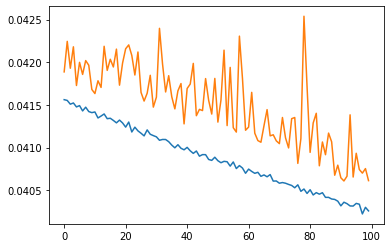

In [24]:
plt.plot(history3.history['loss'])
_ = plt.plot(history3.history['val_loss'])

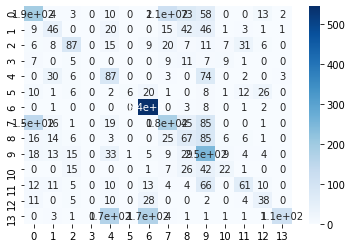

In [31]:
import numpy as np
import seaborn as sns

p_test = model.predict(x_test)
p_test_probs = tf.nn.softmax(p_test).numpy()
y_test_probs = tf.identity(y_test).numpy()
p_test_class = np.argmax(p_test_probs, axis=1)
y_test_class = np.argmax(y_test_probs, axis=1)

_ = sns.heatmap(tf.math.confusion_matrix(y_test_class, p_test_class), cmap='Blues', annot=True)